# Gaussian PDF

$$
\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{d/2} |\boldsymbol{\Sigma}|^{1/2}} e^{-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\intercal \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})}
$$

$$L(\theta) = \sum_{i} \log \left( \sum_{j} \pi_{j} N(x_{i} | \mu_{j}, \Sigma_{j}) \right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
class GMM:
    def __init__(self, n_components, max_iterations=1000, tol=1e-4):
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tol = tol
        self.log_likelihoods = []

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        np.random.seed(0)
        random_indices = np.random.choice(n_samples, size=self.n_components, replace=False)
        # print("random indices")
        # print(random_indices)
        
        self.means = X[random_indices]
        # print("means")
        # print(self.means)
        # shape = no. of gaussians, no. of features

        self.covariances = [np.eye(n_features) for _ in range(self.n_components)]
        # print("covariances")
        # print(self.covariances)
        # shape = no. of gaussians, no. of features, no. of features

        self.mixing_coefficients = np.ones(self.n_components) / self.n_components
        # print("mixing coefficients")
        # print(self.mixing_coefficients)
        # shape = no. of gaussians

    # routine to get parameters and mixing coefficients
    def get_parameters(self):
        return self.means, self.covariances, self.mixing_coefficients

    def gaussian_pdf(self, x, mean, cov):

        D = len(mean)
        det  = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        norm = 1.0 / ((2 * np.pi) ** (D / 2) * det ** 0.5)
        exponent = -0.5 * np.dot(np.dot((x - mean).T, inv), (x - mean))
        # np.exp gives e^(exponent)
        return norm * np.exp(exponent)

    def expectation_step(self, X):
        n_samples = X.shape[0]
        self.responsibilities = np.zeros((n_samples, self.n_components))

        for i in range(n_samples):
            for j in range(self.n_components):
                # calculate the posterior probability of each sample for each gaussian
                self.responsibilities[i, j] = self.mixing_coefficients[j] * self.gaussian_pdf(X[i], self.means[j], self.covariances[j])

            self.responsibilities[i] /= np.sum(self.responsibilities[i])

    def maximization_step(self, X):
        n_samples = X.shape[0]
        n_features = X.shape[1]

        for j in range(self.n_components):
            Nj = np.sum(self.responsibilities[:, j])
                                        # to make it a column vector for broadcasting
            self.means[j] = np.sum(X * self.responsibilities[:, j][:, np.newaxis], axis=0) / Nj
            # Inside the maximization_step method, before updating covariances
            # we add a regularization term to the covariance matrix to avoid numerical instability
            # REGULARIZATION_TERM = 1e-6
            # self.covariances[j] += np.eye(n_features) * REGULARIZATION_TERM
            diff = X - self.means[j]
            self.covariances[j] = np.dot(diff.T, diff * self.responsibilities[:, j][:, np.newaxis]) / Nj
            self.covariances[j] += np.eye(n_features) * 1e-4
            
            
        self.mixing_coefficients = np.mean(self.responsibilities, axis=0)
        
        self.log_likelihoods.append(self.log_likelihood(X))
    #  routine to fit data
    def fit(self, X):
        self.initialize_parameters(X)
        self.X = X

        for iteration in range(self.max_iterations):
            prev_means = np.copy(self.means)

            self.expectation_step(X)
            self.maximization_step(X)

            # Check for convergence
            if np.all(np.abs(self.means - prev_means) < self.tol):
                break
    # routing to predict the cluster
    def predict(self):
        self.expectation_step(self.X)
        return np.argmax(self.responsibilities, axis=1)
    
    def log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = 0.0
        # summation of log likelihoods of all samples
        for i in range(n_samples):
            likelihood = 0.0
            # summation of likelihoods of all gaussians
            for j in range(self.n_components):
                likelihood += self.mixing_coefficients[j] * self.gaussian_pdf(X[i], self.means[j], self.covariances[j])
            log_likelihood += np.log(likelihood)

        return log_likelihood

    def aic(self, X):
        log_likelihood = self.log_likelihood(X)
        n_features = X.shape[1]
                     # 3 GAUSSIANS        # FOR MEAN   # FOR COVARIANCE                       # FOR MIXING COEFFICIENTS
        num_params = (self.n_components * (n_features + n_features * (n_features + 1) / 2)) + (self.n_components - 1)
        aic = -2 * log_likelihood + 2 * num_params
        return aic

    def bic(self, X):
        log_likelihood = self.log_likelihood(X)
        n_samples, n_features = X.shape
        
        num_params =  self.n_components * (n_features + n_features * (n_features + 1) / 2) + (self.n_components - 1)
        bic = -2 * log_likelihood + np.log(n_samples) * num_params
        return bic

# Customer Dataset

In [4]:
data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')
data.head()

# one hot encode settlement size in data
# data = pd.get_dummies(data, columns=['Settlement size'])
# min max scaling for age and income
data['Age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
data['Income'] = (data['Income'] - data['Income'].min()) / (data['Income'].max() - data['Income'].min())
data.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,0.844828,2,0.324781,1,2
1,1,1,1,0.068966,1,0.420210,1,2
2,2,0,0,0.534483,1,0.195144,0,0
3,3,0,0,0.465517,1,0.496223,1,1
4,4,0,0,0.603448,1,0.413842,1,1


In [5]:
# add 1 to gender marital status and age occupation settlement size
X = data.values[:, 1:]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

X.shape
# PCA 
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

(2000, 7)

No of Gaussians :  1
Mean :
[[0.457      0.4965     0.30877586 1.038      0.3111973  0.8105
  0.739     ]]
Covariance :
[array([[ 0.248251  ,  0.1410995 , -0.01840367,  0.073134  , -0.01354027,
        -0.0643985 , -0.121723  ],
       [ 0.1410995 ,  0.25008775, -0.02153135,  0.112133  , -0.00512058,
        -0.00941325, -0.0394135 ],
       [-0.01840367, -0.02153135,  0.04090729,  0.07929238,  0.00958375,
         0.01397854,  0.01965084],
       [ 0.073134  ,  0.112133  ,  0.07929238,  0.359656  ,  0.01949854,
         0.024701  ,  0.016918  ],
       [-0.01354027, -0.00512058,  0.00958375,  0.01949854,  0.01950071,
         0.0605003 ,  0.05554144],
       [-0.0643985 , -0.00941325,  0.01397854,  0.024701  ,  0.0605003 ,
         0.40768975,  0.2965405 ],
       [-0.121723  , -0.0394135 ,  0.01965084,  0.016918  ,  0.05554144,
         0.2965405 ,  0.659979  ]])]
Mixing Coefficients :
[1.]


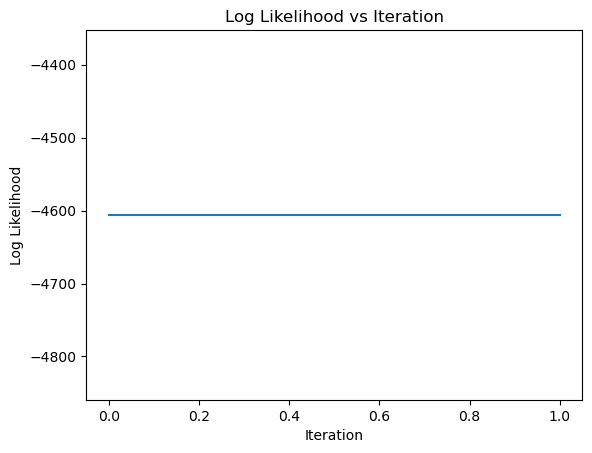

No of Gaussians :  2
Mean :
[[0.60200785 0.53504358 0.28082353 1.00900623 0.23772641 0.42055781
  0.        ]
 [0.31575007 0.45895529 0.3360038  1.06624239 0.38276417 1.19033674
  1.45884861]]
Covariance :
[array([[ 2.39694399e-01,  1.12716159e-01, -1.24453626e-02,
         7.23737759e-02, -6.05052603e-04, -5.79422366e-03,
         0.00000000e+00],
       [ 1.12716159e-01,  2.48871948e-01, -1.89289258e-02,
         1.01294427e-01,  2.82613389e-03,  2.53066884e-02,
         0.00000000e+00],
       [-1.24453626e-02, -1.89289258e-02,  3.41443016e-02,
         6.78971380e-02,  4.28548396e-03, -4.76797818e-03,
         0.00000000e+00],
       [ 7.23737759e-02,  1.01294427e-01,  6.78971380e-02,
         3.12474518e-01,  1.32854157e-02,  7.67069074e-04,
         0.00000000e+00],
       [-6.05052603e-04,  2.82613389e-03,  4.28548396e-03,
         1.32854157e-02,  9.21423156e-03,  3.14404185e-02,
         0.00000000e+00],
       [-5.79422366e-03,  2.53066884e-02, -4.76797818e-03,
         7.670

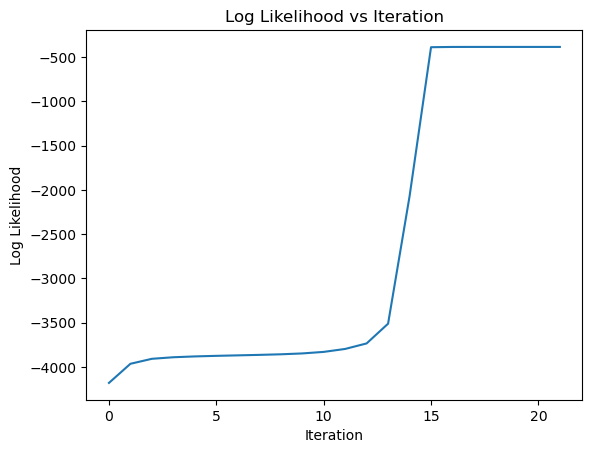

No of Gaussians :  3
Mean :
[[0.6081851  0.52817727 0.27713823 0.99746833 0.23116162 0.39939145
  0.        ]
 [0.37077705 0.37077705 0.34627994 1.02266268 0.38760164 1.18811486
  1.42302102]
 [0.07185072 0.92814928 0.29675879 1.32425719 0.36870689 1.1765318
  1.37208779]]
Covariance :
[array([[ 2.38395983e-01,  1.14197993e-01, -1.21749702e-02,
         7.32339923e-02,  6.46165241e-04, -1.59031240e-03,
         0.00000000e+00],
       [ 1.14197993e-01,  2.49306041e-01, -1.99812464e-02,
         9.83357609e-02,  1.24713488e-03,  2.04771773e-02,
         0.00000000e+00],
       [-1.21749702e-02, -1.99812464e-02,  3.26494674e-02,
         6.34041649e-02,  3.50250343e-03, -8.19589469e-03,
         0.00000000e+00],
       [ 7.32339923e-02,  9.83357609e-02,  6.34041649e-02,
         2.99578543e-01,  1.07738267e-02, -1.06831865e-02,
         0.00000000e+00],
       [ 6.46165241e-04,  1.24713488e-03,  3.50250343e-03,
         1.07738267e-02,  7.66252149e-03,  2.71348978e-02,
         0.0000000

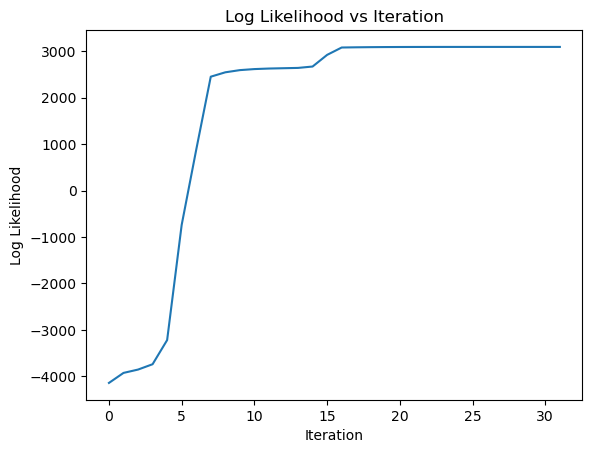

No of Gaussians :  4
Mean :
[[0.70297522 0.95172327 0.27753447 1.22706973 0.34334957 1.11564012
  1.        ]
 [0.18784239 0.18784239 0.36941151 0.9472697  0.40223685 1.2269068
  1.56487759]
 [0.07215074 1.         0.26541839 1.48829419 0.35832485 1.11896753
  2.        ]
 [0.60477756 0.53754481 0.27998982 1.00901723 0.23667478 0.4183107
  0.        ]]
Covariance :
[array([[ 2.08901061e-01, -1.43272060e-02, -1.27541398e-02,
        -2.53719859e-02, -1.00992114e-02, -3.24837622e-02,
         0.00000000e+00],
       [-1.43272060e-02,  4.60460841e-02,  2.72235103e-04,
         7.24864030e-03,  1.01679526e-03, -1.84649758e-03,
         0.00000000e+00],
       [-1.27541398e-02,  2.72235103e-04,  4.18610435e-02,
         7.57759915e-02,  9.89990767e-03, -3.65606033e-03,
         0.00000000e+00],
       [-2.53719859e-02,  7.24864030e-03,  7.57759915e-02,
         1.79585850e-01,  1.86719202e-02, -2.91926252e-03,
         0.00000000e+00],
       [-1.00992114e-02,  1.01679526e-03,  9.89990767e-

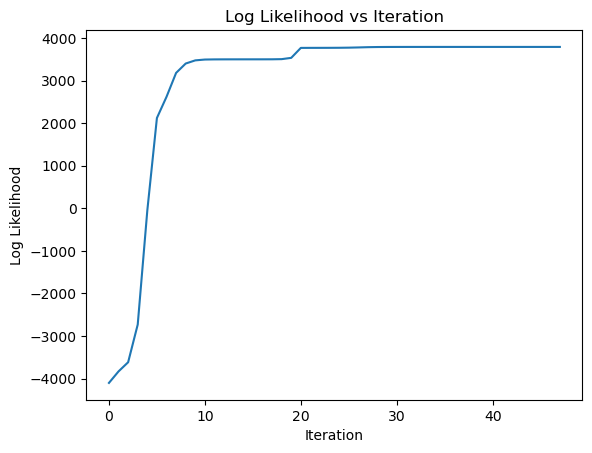

No of Gaussians :  5
Mean :
[[0.77106881 0.97125163 0.17705947 1.         0.30769966 1.07465047
  0.50936096]
 [0.08710661 0.08710661 0.40273368 0.94320471 0.4039877  1.21488355
  1.43220756]
 [0.59108579 1.         0.27515268 1.40936127 0.37929387 1.1888994
  2.        ]
 [0.5560328  0.41718688 0.30627717 1.00789707 0.21966947 0.24363784
  0.        ]
 [0.03846154 0.96153846 0.57758621 2.         0.42860574 1.19230769
  1.        ]]
Covariance :
[array([[ 1.76621699e-01, -6.58139023e-03, -3.96539893e-03,
         0.00000000e+00, -4.81175940e-03, -2.32912146e-02,
        -1.56361814e-02],
       [-6.58139023e-03,  2.80218973e-02, -1.76647684e-03,
         0.00000000e+00, -5.12463975e-04, -2.64530703e-03,
        -1.41050227e-02],
       [-3.96539893e-03, -1.76647684e-03,  7.38482428e-03,
         0.00000000e+00,  1.86442112e-03,  2.84178432e-03,
         1.91988809e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e-04,  0.00000000e+00,  0.00000000e+00

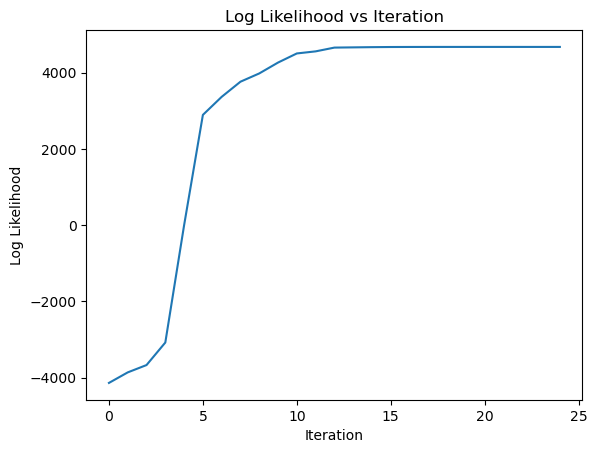

No of Gaussians :  6
Mean :
[[0.76908211 0.97106254 0.17738441 1.         0.30617337 1.07361131
  0.50867177]
 [0.11858525 0.11858525 0.40347584 0.95547503 0.41253561 1.24386798
  1.29084105]
 [0.         0.         0.41451905 1.         0.3571941  1.
  2.        ]
 [0.55717112 0.41433762 0.3011864  0.99223315 0.21666299 0.23298084
  0.        ]
 [0.0370367  0.9629633  0.58301254 2.         0.43658543 1.22219905
  0.96295452]
 [0.59101973 1.         0.27513801 1.40936839 0.37929145 1.18888541
  2.        ]]
Covariance :
[array([[ 1.77694816e-01, -6.68216813e-03, -3.99146824e-03,
         0.00000000e+00, -5.21599865e-03, -2.38036187e-02,
        -1.56757691e-02],
       [-6.68216813e-03,  2.82000869e-02, -1.76869320e-03,
         0.00000000e+00, -5.60001469e-04, -2.69277665e-03,
        -1.42177386e-02],
       [-3.99146824e-03, -1.76869320e-03,  7.42502012e-03,
         0.00000000e+00,  1.91032242e-03,  2.85911581e-03,
         1.81163915e-03],
       [ 0.00000000e+00,  0.00000000e+00,

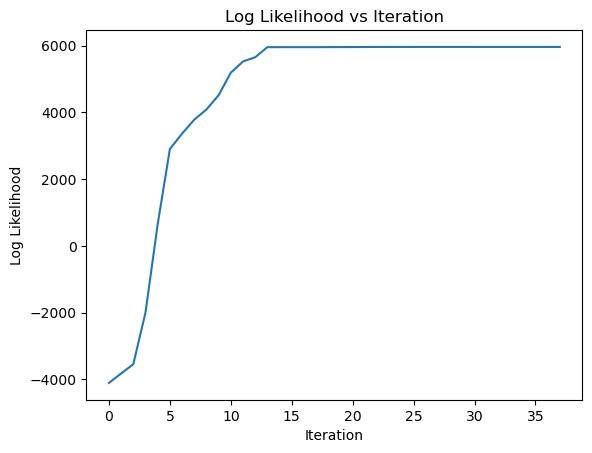

No of Gaussians :  7
Mean :
[[0.64085676 0.35914324 0.24786728 1.         0.32997424 1.29558283
  0.53744708]
 [1.         1.         0.33898541 1.43798217 0.26204657 0.34303965
  0.18310711]
 [0.         0.         0.36354561 0.79010856 0.34157181 0.92762364
  0.97708082]
 [0.68818477 0.31181523 0.29157384 0.9830495  0.19474896 0.0887968
  0.        ]
 [0.10331369 0.89668631 0.60221791 2.06882572 0.42280732 1.17254558
  0.89668707]
 [0.65829411 1.         0.43439109 1.97967171 0.4835672  1.35284412
  2.        ]
 [0.74923268 1.         0.16999631 1.         0.29641597 1.
  0.79746697]]
Covariance :
[array([[ 2.30259372e-01, -2.30159372e-01,  1.16190374e-02,
         0.00000000e+00, -2.40649737e-02, -1.80022402e-01,
        -2.00843761e-01],
       [-2.30159372e-01,  2.30259372e-01, -1.16190374e-02,
         0.00000000e+00,  2.40649737e-02,  1.80022402e-01,
         2.00843761e-01],
       [ 1.16190374e-02, -1.16190374e-02,  1.36182502e-02,
         0.00000000e+00,  3.11080238e-04, -9.

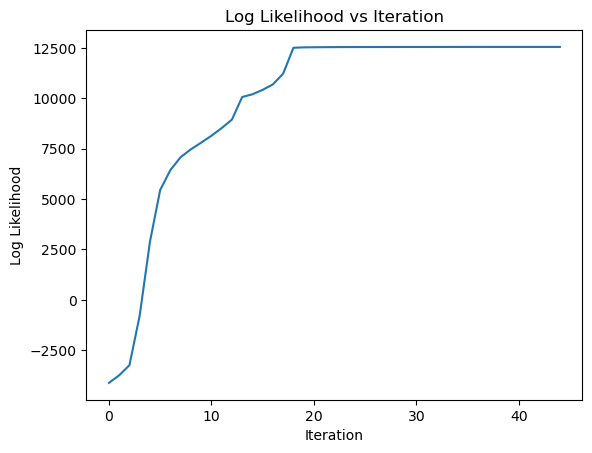

No of Gaussians :  8
Mean :
[[0.07308626 0.92691374 0.19331754 1.         0.320921   1.13325668
  1.08441192]
 [1.         1.         0.46570338 1.71513004 0.52203    1.71745539
  1.28499723]
 [0.         0.         0.36354561 0.79010856 0.34157181 0.92762364
  0.97708082]
 [0.81579646 1.         0.17740314 1.         0.17863022 0.
  0.        ]
 [0.01886862 0.98113138 0.56343818 2.         0.39789345 1.01883174
  0.94335725]
 [0.50428961 1.         0.40059455 2.65116261 0.5712749  1.39793392
  2.        ]
 [1.         1.         0.21831837 1.13786727 0.30751484 1.
  0.76334836]
 [1.         0.2740907  0.3760153  1.2645009  0.22901581 0.25644513
  0.        ]]
Covariance :
[array([[ 6.78446627e-02, -6.77446627e-02,  3.28965681e-03,
         0.00000000e+00,  3.18523424e-04,  2.36826247e-03,
        -6.55761098e-03],
       [-6.77446627e-02,  6.78446627e-02, -3.28965681e-03,
         0.00000000e+00, -3.18523424e-04, -2.36826247e-03,
         6.55761098e-03],
       [ 3.28965681e-03, -3.2

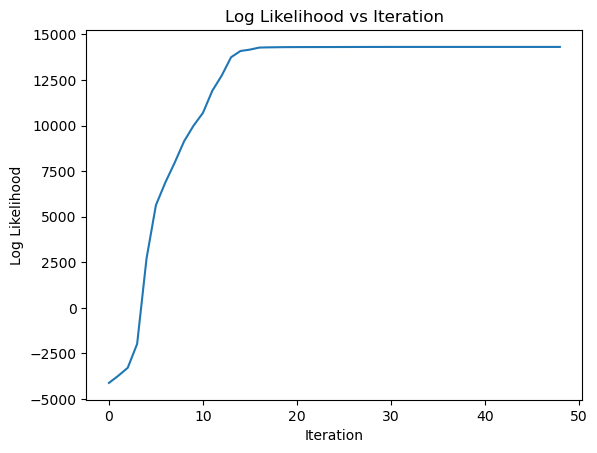

No of Gaussians :  9
Mean :
[[0.12862832 0.8969622  0.22019719 1.         0.36923193 1.48603608
  1.23057593]
 [0.80563455 0.80563455 0.48026602 1.62819288 0.60442838 2.
  1.35481714]
 [0.         0.         0.3737949  0.81266349 0.38799674 1.18767006
  1.46186836]
 [0.3739617  0.         0.31857895 0.78696508 0.22560148 0.34889266
  0.        ]
 [0.60060115 1.         0.56518333 2.         0.40480984 1.06028683
  1.07115454]
 [0.54462386 1.         0.39766678 2.55286865 0.5536281  1.40418743
  2.        ]
 [0.75059075 1.         0.16991632 1.         0.29824986 1.
  0.79867971]
 [1.         0.52613048 0.55769142 2.10485618 0.37885453 1.10496756
  0.62990937]
 [0.8282685  1.         0.2593891  1.23013583 0.19135888 0.
  0.        ]]
Covariance :
[array([[ 1.12183078e-01, -8.97842200e-02,  1.24559584e-02,
         0.00000000e+00, -8.99113932e-03, -8.80823594e-02,
        -2.97311857e-02],
       [-8.97842200e-02,  9.25210113e-02, -1.05902491e-02,
         0.00000000e+00,  1.19022473e-02

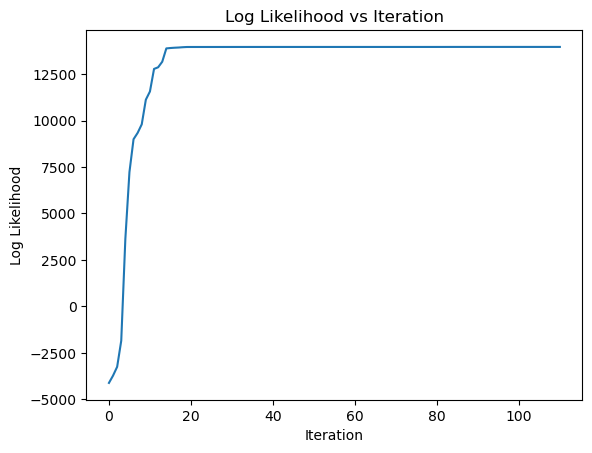

In [7]:
for i in range(1, 10):
    gmm = GMM(n_components=i)
    gmm.fit(X)
    clusters = gmm.predict()
    mean, covariance, mixing_coefficients = gmm.get_parameters()
    # print(mean, covariance, mixing_coefficients)
    print("No of Gaussians : ", i)
    print("Mean :")
    print(mean)
    print("Covariance :")
    print(covariance)
    print("Mixing Coefficients :")
    print(mixing_coefficients)

    plt.plot(range(len(gmm.log_likelihoods)), gmm.log_likelihoods)
    plt.title('Log Likelihood vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.show()

In [ ]:
# Find the parameters of GMM associated with the customer-dataset, us-
# ing the EM method. Vary the number of components, and observe the
# results. Implement GMM in a class which has the routines to fit data (e.g.
# gmm.fit(data, number of clusters)), a routine to obtain the parameters, a
# routine to calculate the likelihoods for a given set of samples and a routine
# to obtain the membership values of data samples.

# Wine Dataset

In [4]:
# Load the wine dataset and standardize it
wine = load_wine()
X = wine.data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans and GMM

GMM :


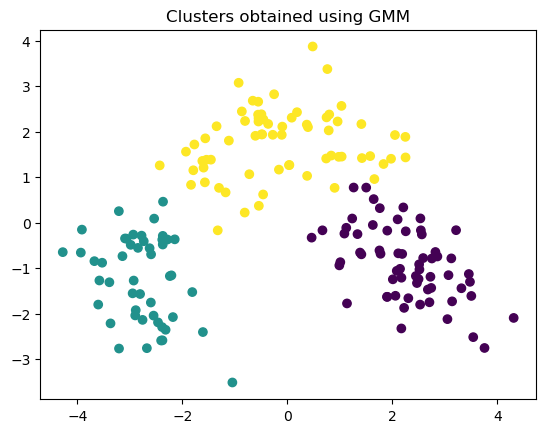

KMeans :


/home/prakhar/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


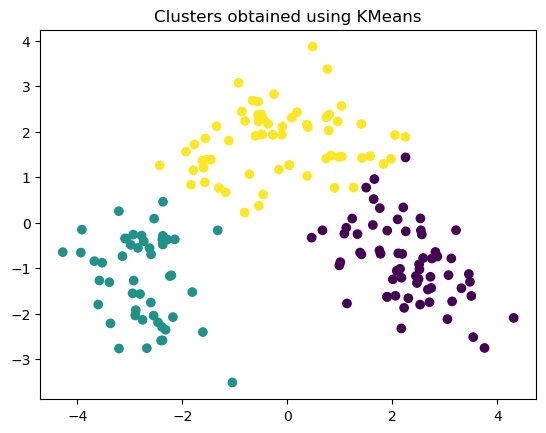

Silhouette Score for GMM :  0.558147346129322
Silhouette Score for KMeans :  0.5610505693103246


In [ ]:
# Taking 3 gaussian components
gmm = GMM(n_components=3)
gmm.fit(X_pca)
y_pred = gmm.predict()

print("GMM :")

# Plot the clusters obtained using GMM
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.title('Clusters obtained using GMM')
plt.show()

# KMeans
# supress waring messages for kmeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_pca)
y_pred = kmeans.predict(X_pca)
print("KMeans :")
# Plot the clusters obtained using KMeans
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.title('Clusters obtained using KMeans')
plt.show()

# calculate the silhouette score for GMM and KMeans
print("Silhouette Score for GMM : ", silhouette_score(X_pca, gmm.predict()))
print("Silhouette Score for KMeans : ", silhouette_score(X_pca, kmeans.predict(X_pca)))


# AIC, BIC and Silhouette Scores for GMM

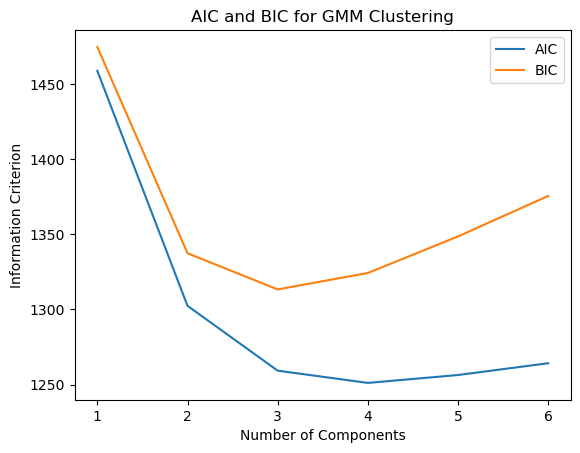

AIC :


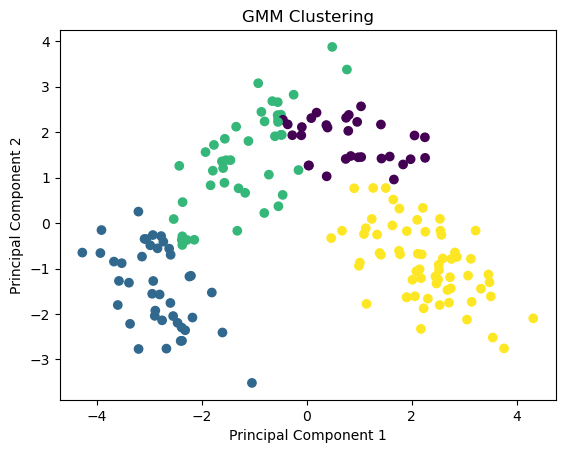

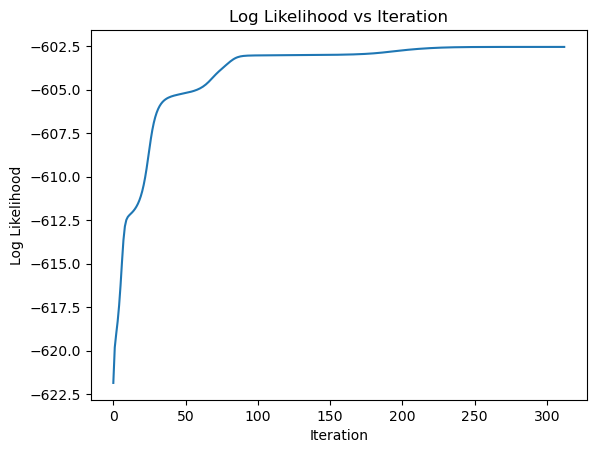

BIC :


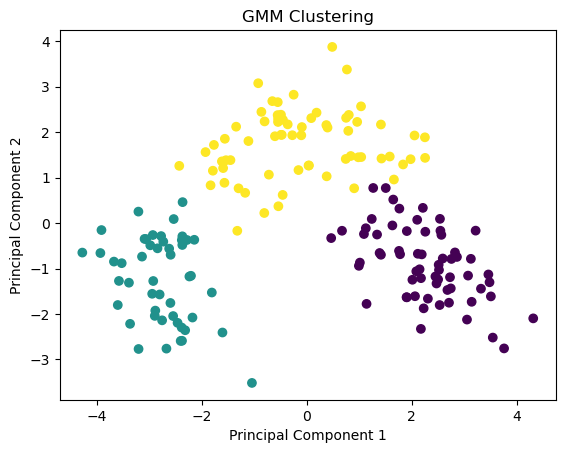

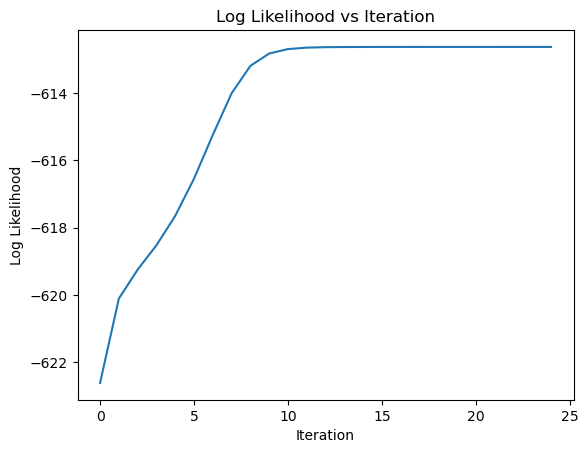

Silhouette Score for AIC :  0.4231602448012105
Silhouette Score for BIC :  0.5581473461293222


In [5]:


# Try different numbers of components and compute AIC and BIC
n_components_range = range(1, 7)
aic_values = []
bic_values = []
min_aic = np.infty # for minimum aic components
min_bic = np.infty # for minimum bic components
best_gmm_aic = None # for gmm object
best_gmm_bic = None # for gmm object
aic_n_components = 0
bic_n_components = 0

for n_components in n_components_range:
    gmm = GMM(n_components)
    gmm.fit(X_pca)
    aic = gmm.aic(X_pca)
    bic = gmm.bic(X_pca)
    aic_values.append(aic)
    bic_values.append(bic)
    # print(aic)
    # print(bic)
    if(aic < min_aic):
        min_aic = aic
        best_gmm_aic = gmm
        aic_n_components = n_components
    if(bic < min_bic):
        min_bic = bic
        best_gmm_bic = gmm
        bic_n_components = n_components



# temporary 
# best_gmm_aic = GMM(4)
# best_gmm_aic.fit(X_pca)
# best_gmm_bic = GMM(3)
# best_gmm_bic.fit(X_pca)


# Plot AIC and BIC values as a function of the number of components
plt.plot(n_components_range, aic_values, label='AIC')
plt.plot(n_components_range, bic_values, label='BIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for GMM Clustering')
plt.show()

print("AIC :")

# print(min_aic)
# best_gmm_aic.fit(X_pca)

cluster_assignments_aic = best_gmm_aic.predict()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments_aic, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot the likelihoods
plt.plot(range(len(best_gmm_aic.log_likelihoods)), best_gmm_aic.log_likelihoods)
plt.title('Log Likelihood vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()

print("BIC :")

# print(min_bic)
# best_gmm_bic.fit(X_pca)

cluster_assignments_bic = best_gmm_bic.predict()

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments_bic, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot the likelihoods
plt.plot(range(len(best_gmm_bic.log_likelihoods)), best_gmm_bic.log_likelihoods)
plt.title('Log Likelihood vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()

# Print Silhouette Score for AIC and BIC

print("Silhouette Score for AIC : ", silhouette_score(X_pca, cluster_assignments_aic))
print("Silhouette Score for BIC : ", silhouette_score(X_pca, cluster_assignments_bic))